In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *
from metal.analysis import confusion_matrix
from metal.utils import convert_labels
from tagger import Tagger

### Load Data

In [2]:
task_name = 'RTE'
split = 'dev'
filepath = f'/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_12_19/{task_name}_{split}_error_analysis.tsv'
df_error = load_dataframe(filepath)

### View Errors

Plotting probabilities from the first column of Y_probs


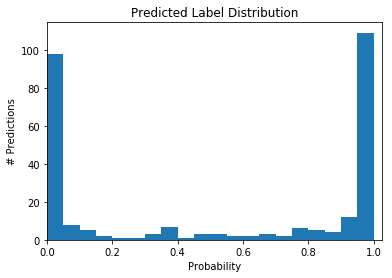

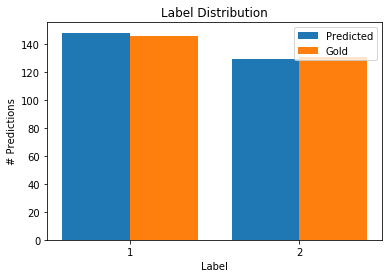

Plotting probabilities from the first column of Y_probs


/dfs/scratch0/mccreery/repos/metal/metal/contrib/visualization/analysis.py:147: RuntimeWarning: invalid value encountered in long_scalars
  bin_accuracy = sum(bin_idxs * correct_idxs) / sum(bin_idxs)


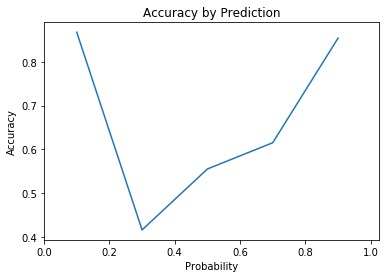

In [3]:
Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()

from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_plot
    )
plot_probabilities_histogram(Y_probs, title="Predicted Label Distribution")
plot_predictions_histogram(Y_preds, Y_gold, title="Label Distribution")
plot_calibration_plot(Y_probs, Y_gold, title="Accuracy by Prediction", bins=5)

In [4]:
# print("\033[1mBARELY RIGHT\033[0;0m")
# print_barely_right(df_error, thresh=0.2, n=1)
# print("\033[1mBARELY WRONG\033[0;0m")
# print_barely_wrong(df_error, thresh=0.2, n=1)
print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0.8, n=10)

VERY WRONG
34 matches were found with the given criteria.

UID:  RTE/dev.tsv:50
sentence1: 	 he became a boxing referee in 1964 and became most well - known for his decision against mike tyson , during the holy ##field fight , when tyson bit holy ##field ' s ear . 
sentence2: 	 mike tyson bit holy ##field ' s ear in 1964 . 
score: 	0.9078
label: 	0

UID:  RTE/dev.tsv:163
sentence1: 	 it has been observed that in those countries of the world where capital punishment is still in operation , the crime rate , especially murder , is distinctive ##ly low in comparison to countries where capital punishment has been discarded . 
sentence2: 	 capital punishment is a deter ##rent to crime . 
score: 	0.0918
label: 	1

UID:  RTE/dev.tsv:40
sentence1: 	 amazon shares fell nearly 4 percent following the results as the company said operating income would drop as much as 42 percent in the second quarter . 
sentence2: 	 shares of amazon fell 4 percent . 
score: 	0.9887
label: 	0

UID:  RTE/dev.tsv:210


In [5]:
i = np.random.randint(df_error.shape[0])
row = df_error.iloc[1]
print('sentence 1: ', row.sentence1.replace(" ##", ""))
print('sentence 2: ', str(row.sentence2).replace(" ##", ""))
print()
print('label: ', row.label)
print('score: ', row.score)
print('uid: ', row.uid)

sentence 1:   yet , we now are discovering that antibiotics are losing their effectiveness against illness . disease - causing bacteria are mutating faster than we can come up with new antibiotics to fight the new variations . 
sentence 2:   bacteria is winning the war against antibiotics . 

label:  1
score:  0.008030015043914318
uid:  RTE/dev.tsv:3


In [18]:
tagger = Tagger(tags_dir='slices')
tagger.get_examples('COLA_dev_morepeople')

[('CoLA/dev.tsv:11',
  {'sent1': 'The more Fred is obnoxious, the less attention you should pay to him.',
   'sent2': None,
   'label': '1'}),
 ('CoLA/dev.tsv:61',
  {'sent1': "I know which book Mag read, and which book Bob read my report that you hadn't.",
   'sent2': None,
   'label': '0'}),
 ('CoLA/dev.tsv:75',
  {'sent1': 'He attributed to a short circuit which was caused by an overloaded transducer the fire which destroyed most of my factory.',
   'sent2': None,
   'label': '1'}),
 ('CoLA/dev.tsv:100',
  {'sent1': "I won't ask you to believe that he tried to force me to give her any money.",
   'sent2': None,
   'label': '1'}),
 ('CoLA/dev.tsv:103',
  {'sent1': "That the fuzz wanted him worried John, but that the fuzz wanted her didn't worry Mary.",
   'sent2': None,
   'label': '1'}),
 ('CoLA/dev.tsv:119',
  {'sent1': 'That girl was given my binoculars by him.',
   'sent2': None,
   'label': '1'}),
 ('CoLA/dev.tsv:223',
  {'sent1': 'He washed her.', 'sent2': None, 'label': '1'}),

# Slicing

In [13]:
model_path = ''
task_name = 'COLA'
split = 'dev'
# multi task
filepath = f'/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_12_19/{task_name}_{split}_error_analysis.tsv'
# single task
# filepath = f'{task_name}_{split}_error_analysis.tsv'
print(filepath)
df_error = load_dataframe(filepath)
df_error.head()

/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_12_19/COLA_dev_error_analysis.tsv


,Unnamed: 0,sentence1,sentence2,score,label,uid,pred,is_wrong
0,0,the weights made the rope stretch over the pu...,NaN,0.977936,1,CoLA/dev.tsv:2,1,False
1,1,the mechanical doll wr ##ig ##gled itself loo...,NaN,0.979236,1,CoLA/dev.tsv:3,1,False
2,2,"if you had eaten more , you would want less .",NaN,0.997094,1,CoLA/dev.tsv:4,1,False
3,3,"as you eat the most , you want the least .",NaN,0.722893,0,CoLA/dev.tsv:5,1,True
4,4,"the more you would want , the less you would ...",NaN,0.979076,0,CoLA/dev.tsv:6,1,True


In [14]:
from metal.mmtl.debugging.utils import print_row, apply_lfs_to_df, view_matches
from metal.mmtl.debugging.lf_helpers import regex_present
from nltk.translate.bleu_score import sentence_bleu

In [15]:
def slice_function(row):
    sent1 = row['sentence1']
    sent2 = row['sentence2']
    for num in range(10):
        if str(num) in sent2 and str(num) not in sent1:
            return True
    return False

from slicing import slice_dashsemicolon, slice_morepeople, slice_endquestionword, slice_lowbleu
    
df = df_error[['sentence1','sentence2']].apply(slice_morepeople, axis=1)

in_slice = df_error[df]
print(in_slice.head())

     Unnamed: 0                                          sentence1  sentence2  \
9             9   the more fred is ob ##no ##xious , the less a...        NaN   
59           59   i know which book mag read , and which book b...        NaN   
73           73   he attributed to a short circuit which was ca...        NaN   
98           98   i won ' t ask you to believe that he tried to...        NaN   
101         101   that the fu ##zz wanted him worried john , bu...        NaN   

        score  label               uid  pred  is_wrong  
9    0.994367      1   CoLA/dev.tsv:11     1     False  
59   0.004204      0   CoLA/dev.tsv:61     0     False  
73   0.750735      1   CoLA/dev.tsv:75     1     False  
98   0.987326      1  CoLA/dev.tsv:100     1     False  
101  0.995970      1  CoLA/dev.tsv:103     1     False  


In [16]:
from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()
print('IN ENTIRE {} DATASET'.format(task_name))

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(df_error)} examples in the dataset')
    
Y_gold = convert_labels(in_slice['label'].values, "onezero", "categorical")
Y_preds = convert_labels(in_slice['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([in_slice['score'].values, 1 - in_slice['score'].values]).transpose()
print('\nIN SLICE')
    
from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(in_slice)} examples in the slice')

IN ENTIRE COLA DATASET
Accuracy: 0.845
Precision: 0.844
Recall: 0.950
F1: 0.894
There are 1042 examples in the dataset

IN SLICE
Accuracy: 0.938
Precision: 0.929
Recall: 1.000
F1: 0.963
There are 16 examples in the slice


In [17]:
filename = f'slices/{task_name}_{split}_morepeople.txt'
print(in_slice)
in_slice['uid'].to_csv(filename,sep='\t',header=False,index=False)

      Unnamed: 0                                          sentence1  \
9              9   the more fred is ob ##no ##xious , the less a...   
59            59   i know which book mag read , and which book b...   
73            73   he attributed to a short circuit which was ca...   
98            98   i won ' t ask you to believe that he tried to...   
101          101   that the fu ##zz wanted him worried john , bu...   
117          117        that girl was given my binoculars by him .    
221          221                                   he washed her .    
235          235          a good friend is remained to me by him .    
301          301    how did you guess that he fixed the computer ?    
309          309   which topic did you choose without getting hi...   
372          372      have you seen my model airplane collection ?    
404          404               i like the book which you gave me .    
547          547   she said she had spoken to everybody , but he...   
562   

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.